## Citrus Prediction (Regression)

### Data
Source: https://dacon.io/competitions/official/236038/data
#### Train Dataset
* Columns:
    * `ID`: unique citrus tree ID
    * `착과량` : actual amount of citrus fruit drop; target variable
    * 5 features related to the growth each tree (height and the maximum/minimum/average width of its crown)
        * `수고(m)`, `수관폭1(min)`, `수관폭2(max)`, `수관폭평균`
    * 89 features representing tree bud measured from 2022/09/01 to 2022/11/28.
        * `2022-09-01 새순` , ... , `2022-11-28 새순`
    * 89 features representing chlorophyl measured from 2022/09/01 to 2022/11/28.
        * `2022-09-01 엽록소` , ... , `2022-11-28 엽록소`
    

#### Test Dataset
* Columns:
    * `ID`: unique citrus tree ID
    * 5 features related to the growth each tree (height and the maximum/minimum/average width of its crown)
        * `수고(m)`, `수관폭1(min)`, `수관폭2(max)`, `수관폭평균`
    * 89 features representing tree bud measured from 2022/09/01 to 2022/11/28.
        * `2022-09-01 새순` , ... , `2022-11-28 새순`
    * 89 features representing chlorophyl measured from 2022/09/01 to 2022/11/28.
        * `2022-09-01 엽록소` , ... , `2022-11-28 엽록소`
    
### Score Measures
* Evaluated with NMAE
* Public score: measured with 30% of the test data
* Private score: measured with the remaining 70% of the test data

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import sklearn
import sklearn.linear_model 
import sklearn.ensemble 

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
import time

import warnings
warnings.filterwarnings('ignore') 

pd.set_option('mode.chained_assignment',  None)
plt.rc('font', family='NanumBarunGothic')  

In [ ]:
print('pandas Version :', pd.__version__)
print('numpy Version :', np.__version__)
print('sklearn Version :', sklearn.__version__)
print('seaborn Version :', sns.__version__)

pandas Version : 1.3.5
numpy Version : 1.21.6
sklearn Version : 1.0.2
seaborn Version : 0.11.2


### Data Loading & EDA

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [ ]:
train.head()

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,...,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,...,71.535483,71.382303,71.253604,71.092665,70.955608,70.796630,70.597550,70.565088,70.560502,70.427600
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,3.0,2.9,2.9,2.9,...,71.279804,71.199570,71.144020,71.026740,70.920038,70.876723,70.710129,70.595971,70.418203,70.399578
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,3.1,3.0,3.0,3.0,...,69.934615,69.884124,69.845683,69.794682,69.779813,69.614644,69.455404,69.281590,69.238689,69.133970
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,3.7,3.6,3.6,3.6,...,68.313016,68.285364,68.209860,68.209458,68.040083,67.859963,67.775556,67.701456,67.504244,67.410093


In [ ]:
test.head()

,ID,수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,...,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TEST_0000,231.0,219.0,302.0,260.5,4.3,4.2,4.2,4.1,4.1,...,72.091497,71.906176,71.886799,71.858720,71.725540,71.531618,71.476935,71.321237,71.184295,71.000223
1,TEST_0001,206.0,324.0,346.0,335.0,2.5,2.5,2.5,2.5,2.5,...,68.423776,68.353200,68.346777,68.188159,67.995233,67.879958,67.744820,67.673522,67.539973,67.447849
2,TEST_0002,282.0,373.0,404.0,388.5,4.7,4.7,4.6,4.6,4.5,...,74.435783,74.247468,74.142664,74.070401,73.892408,73.796143,73.615838,73.440136,73.387051,73.228319
3,TEST_0003,234.0,337.0,357.0,347.0,3.6,3.6,3.6,3.6,3.5,...,73.570735,73.420243,73.313538,73.149298,73.109599,72.924511,72.847411,72.838263,72.672156,72.538171
4,TEST_0004,222.0,329.0,347.0,338.0,2.7,2.7,2.7,2.7,2.6,...,72.216758,72.163153,72.052952,71.905982,71.766141,71.746813,71.668847,71.501043,71.419715,71.328224


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Columns: 184 entries, ID to 2022-11-28 엽록소
dtypes: float64(182), int64(1), object(1)
memory usage: 3.1+ MB


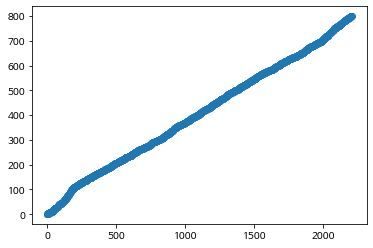

In [ ]:
train.rename(columns={'착과량(int)':'착과량'}, inplace=True)
plt.scatter(train.index, np.sort(train['착과량'].values))

In [ ]:
len(train.columns.unique())

184

In [ ]:
cols_1 = [x for x in train.columns if '새순' in x]
cols_2 = [x for x in train.columns if '엽록소' in x]
print(len(cols_1))
print(len(cols_2))

89
89


In [ ]:
#새순
# plt.figure(figsize = (120, 120))
# colormap = plt.cm.PuBu
# sns.heatmap(train[cols_1].corr(), annot = True, cmap = colormap)
# plt.show()

In [ ]:
#엽록소
# plt.figure(figsize = (120, 120))
# colormap = plt.cm.PuBu
# sns.heatmap(train[cols_2].corr(), annot = True, cmap = colormap)
# plt.show()

* Since there are a lot of columns in the data, I will only keep the features that show some correlation with the target variable (above 0.5 or below -0.5)

In [ ]:
corr_matrix = train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))[:1]
to_drop = [column for column in upper.columns if any(upper[column] < 0.5)]
print("dropped %d columns" %(len(to_drop)))

dropped 100 columns


<ipython-input-33-93966c32a7bb>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))[:1]


In [ ]:
train.drop(to_drop, axis=1, inplace = True)
test.drop(to_drop, axis=1, inplace=True)
train.head()

,ID,착과량,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,2022-09-06 새순,2022-09-07 새순,2022-09-08 새순,...,2022-11-12 새순,2022-11-13 새순,2022-11-14 새순,2022-11-15 새순,2022-11-23 새순,2022-11-24 새순,2022-11-25 새순,2022-11-26 새순,2022-11-27 새순,2022-11-28 새순
0,TRAIN_0000,692,2.8,2.8,2.7,2.7,2.7,2.7,2.6,2.6,...,1.0,1.0,1.0,0.9,0.7,0.7,0.7,0.7,0.7,0.6
1,TRAIN_0001,534,3.3,3.3,3.3,3.2,3.2,3.1,3.1,3.1,...,1.0,0.9,0.9,0.8,0.6,0.5,0.0,0.0,0.0,0.0
2,TRAIN_0002,634,3.0,2.9,2.9,2.9,2.9,2.8,2.8,2.8,...,1.0,1.0,0.9,0.9,0.7,0.7,0.6,0.6,0.6,0.5
3,TRAIN_0003,639,3.1,3.0,3.0,3.0,3.0,2.9,2.9,2.9,...,1.1,1.1,1.1,1.0,0.8,0.8,0.8,0.7,0.7,0.7
4,TRAIN_0004,496,3.7,3.6,3.6,3.6,3.5,3.5,3.5,3.4,...,1.2,1.1,1.1,1.0,0.8,0.7,0.7,0.7,0.6,0.6


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2207 entries, 0 to 2206
Data columns (total 84 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             2207 non-null   object 
 1   착과량            2207 non-null   int64  
 2   2022-09-01 새순  2207 non-null   float64
 3   2022-09-02 새순  2207 non-null   float64
 4   2022-09-03 새순  2207 non-null   float64
 5   2022-09-04 새순  2207 non-null   float64
 6   2022-09-05 새순  2207 non-null   float64
 7   2022-09-06 새순  2207 non-null   float64
 8   2022-09-07 새순  2207 non-null   float64
 9   2022-09-08 새순  2207 non-null   float64
 10  2022-09-09 새순  2207 non-null   float64
 11  2022-09-10 새순  2207 non-null   float64
 12  2022-09-11 새순  2207 non-null   float64
 13  2022-09-12 새순  2207 non-null   float64
 14  2022-09-13 새순  2207 non-null   float64
 15  2022-09-14 새순  2207 non-null   float64
 16  2022-09-15 새순  2207 non-null   float64
 17  2022-09-16 새순  2207 non-null   float64
 18  2022-09-

In [ ]:
train.isnull().sum()

ID               0
착과량              0
2022-09-01 새순    0
2022-09-02 새순    0
2022-09-03 새순    0
                ..
2022-11-24 새순    0
2022-11-25 새순    0
2022-11-26 새순    0
2022-11-27 새순    0
2022-11-28 새순    0
Length: 84, dtype: int64

In [ ]:
train.corr().head()

,착과량,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,2022-09-06 새순,2022-09-07 새순,2022-09-08 새순,2022-09-09 새순,...,2022-11-12 새순,2022-11-13 새순,2022-11-14 새순,2022-11-15 새순,2022-11-23 새순,2022-11-24 새순,2022-11-25 새순,2022-11-26 새순,2022-11-27 새순,2022-11-28 새순
착과량,1.000000,-0.980777,-0.980766,-0.980633,-0.980772,-0.980526,-0.980885,-0.980784,-0.980261,-0.980388,...,-0.749539,-0.697841,-0.635049,-0.544563,0.557371,0.582726,0.546006,0.603445,0.704241,0.769204
2022-09-01 새순,-0.980777,1.000000,0.998097,0.998532,0.998446,0.998555,0.998277,0.998358,0.998242,0.998249,...,0.771072,0.721664,0.655642,0.566983,-0.556788,-0.583302,-0.543855,-0.602950,-0.705765,-0.773815
2022-09-02 새순,-0.980766,0.998097,1.000000,0.998091,0.998492,0.998385,0.998564,0.998295,0.998292,0.998213,...,0.771230,0.720398,0.654854,0.565656,-0.557547,-0.584870,-0.544463,-0.604538,-0.706638,-0.773221
2022-09-03 새순,-0.980633,0.998532,0.998091,1.000000,0.997982,0.998491,0.998386,0.998607,0.998280,0.998256,...,0.772352,0.723094,0.656561,0.568190,-0.554846,-0.582715,-0.543134,-0.602024,-0.704716,-0.772613
2022-09-04 새순,-0.980772,0.998446,0.998492,0.997982,1.000000,0.998016,0.998393,0.998342,0.998481,0.998144,...,0.772649,0.722548,0.657230,0.567903,-0.554963,-0.583703,-0.543055,-0.602929,-0.705140,-0.772696


In [ ]:
train.shape

(2207, 84)

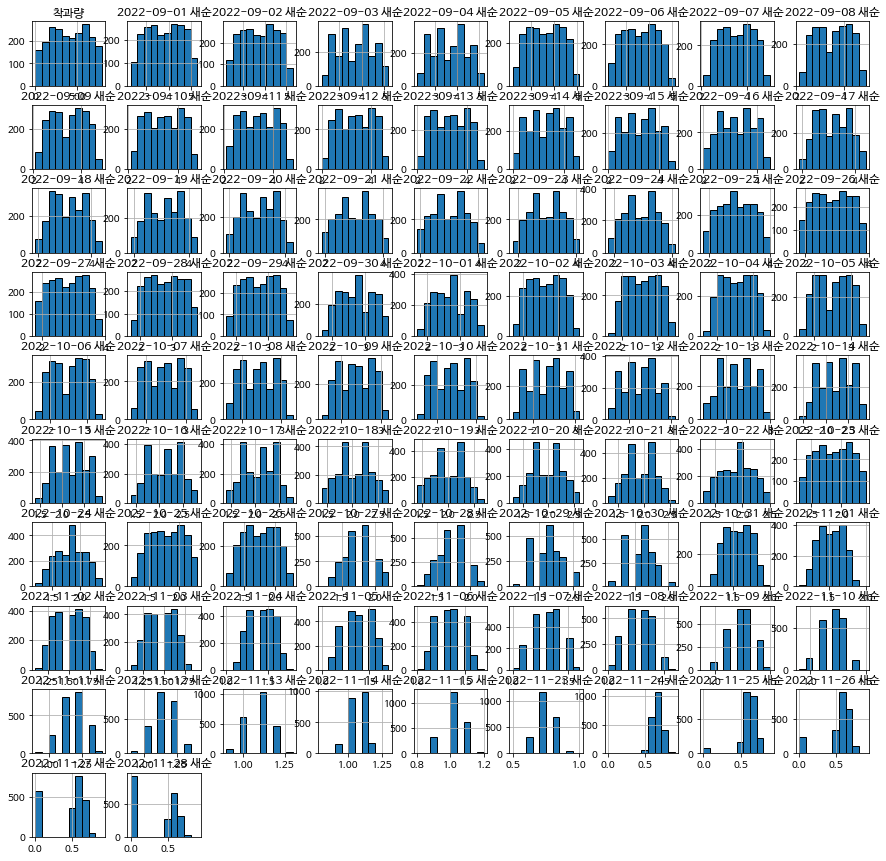

In [ ]:
train.hist(figsize=(15, 15), edgecolor="black")
plt.show()
#plt.tight_layout()

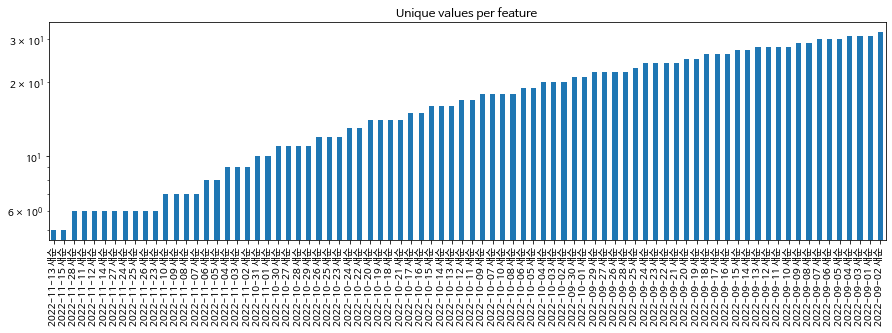

In [ ]:
# Observe 
unique_values = train.drop('착과량', axis=1).select_dtypes(include="number").nunique().sort_values()
unique_values.plot.bar(logy=True, figsize=(15, 4), title="Unique values per feature")

In [ ]:
train.describe()

,착과량,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,2022-09-06 새순,2022-09-07 새순,2022-09-08 새순,2022-09-09 새순,...,2022-11-12 새순,2022-11-13 새순,2022-11-14 새순,2022-11-15 새순,2022-11-23 새순,2022-11-24 새순,2022-11-25 새순,2022-11-26 새순,2022-11-27 새순,2022-11-28 새순
count,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,...,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000,2207.000000
mean,406.222474,3.774807,3.736928,3.701495,3.663435,3.627503,3.590122,3.553285,3.516130,3.479157,...,1.125963,1.088536,1.052288,1.015179,0.721069,0.682102,0.632170,0.559991,0.454599,0.352832
std,218.978302,0.774181,0.764067,0.754751,0.745394,0.733896,0.726348,0.714718,0.705003,0.695087,...,0.087946,0.081074,0.074506,0.069258,0.071919,0.089075,0.142182,0.208367,0.277022,0.305332
min,1.000000,2.300000,2.200000,2.200000,2.200000,2.200000,2.200000,2.100000,2.100000,2.100000,...,0.900000,0.900000,0.800000,0.800000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.000000,3.100000,3.100000,3.050000,3.000000,3.000000,3.000000,2.900000,2.900000,2.900000,...,1.100000,1.000000,1.000000,1.000000,0.700000,0.600000,0.600000,0.500000,0.000000,0.000000
50%,404.000000,3.800000,3.700000,3.700000,3.700000,3.600000,3.600000,3.600000,3.500000,3.500000,...,1.100000,1.100000,1.100000,1.000000,0.700000,0.700000,0.600000,0.600000,0.600000,0.500000
75%,593.500000,4.400000,4.400000,4.300000,4.300000,4.300000,4.200000,4.200000,4.100000,4.100000,...,1.200000,1.100000,1.100000,1.100000,0.800000,0.700000,0.700000,0.700000,0.600000,0.600000
max,799.000000,5.300000,5.300000,5.200000,5.200000,5.100000,5.100000,5.000000,4.900000,4.900000,...,1.400000,1.300000,1.300000,1.200000,1.000000,0.900000,0.900000,0.900000,0.900000,0.900000


In [ ]:
# n_columns = 4
# n_rows = 21
# _, axes = plt.subplots(n_rows, n_columns, figsize=(5 * n_columns, 3 * n_rows))
# for i, c in enumerate(train.select_dtypes(exclude='object')):
#     sns.boxplot(y = c, data = train, ax = axes[i // n_columns, i % n_columns])
# plt.tight_layout()
# plt.show()

* Boxplots show no significant outliers

In [ ]:
train.drop(['ID'], axis=1, inplace=True)
test.drop(['ID'], axis=1, inplace=True)

In [ ]:
# Check multicollinearity
pd.set_option('display.max_rows', None)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train.values, i) for i in range(train.shape[1])]
vif["features"] = train.columns
vif = vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)
vif

,VIF Factor,features
0,18405.779231,2022-09-07 새순
1,17902.589115,2022-09-05 새순
2,17864.917919,2022-09-08 새순
3,17315.206794,2022-09-06 새순
4,17134.315071,2022-09-03 새순
5,16797.308513,2022-09-09 새순
6,16500.074726,2022-09-04 새순
7,16463.627625,2022-09-11 새순
8,16395.360804,2022-09-10 새순
9,16126.937603,2022-09-02 새순


In [ ]:
sept_cols = [x for x in train.columns if '2022-09' in x]
oct_cols = [x for x in train.columns if '2022-10' in x]
train2 = train.drop(sept_cols + oct_cols, axis = 1)
train2['새순_sep_med'] = train[sept_cols].median(axis=1)
train2['새순_oct_med'] = train[oct_cols].median(axis=1)

In [ ]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    train2.values, i) for i in range(train2.shape[1])]
vif["features"] = train2.columns
vif = vif.sort_values("VIF Factor", ascending=False).reset_index(drop=True)
vif

,VIF Factor,features
0,4001.891033,새순_oct_med
1,3406.557980,새순_sep_med
2,2665.225332,2022-11-01 새순
3,2643.795562,2022-11-02 새순
4,2530.164372,2022-11-03 새순
5,2459.653718,2022-11-04 새순
6,2455.690768,2022-11-05 새순
7,2378.107173,2022-11-06 새순
8,2278.898212,2022-11-07 새순
9,2163.885633,2022-11-08 새순


* VIF factors are incredibly high
* The model performance does not improve when september~october data are replaced with mean/median
* This approach of feature selection may not be suitable for this problem
* [Source1](https://towardsdatascience.com/how-to-remove-multicollinearity-using-python-4da8d9d8abb2), [Source2](https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html#:~:text=%EB%8B%A4%EC%A4%91%20%EA%B3%B5%EC%84%A0%EC%84%B1%EC%9D%84%20%EC%97%86%EC%95%A0%EB%8A%94,%ED%95%9C%20%EC%84%B1%EB%8A%A5%EC%9D%84%20%EB%82%98%ED%83%80%EB%82%B8%20%EA%B2%83%EC%9D%B4%EB%8B%A4)

## Model

* 5 regression models were tested based on stratified k-fold.
* 3 best performing models were selected for the final ensemble model.

In [140]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [141]:
X = train.drop('착과량', axis = 1)
y = train['착과량']
n_splits = 7

kf = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 42)

### GradientBoostingRegressor

In [142]:
gbm = GradientBoostingRegressor(random_state = 42)
gb_nmae_list = []
gb_pred = np.zeros((test.shape[0]))
n=0
for tr_idx, val_idx in kf.split(X, y) :
    start_time = time.time()
    n+=1
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]

    gbm.fit(tr_x, tr_y)
    end_time = time.time()
    
    pred = gbm.predict(val_x)
    sub_pred = gbm.predict(test)
    nmae = NMAE(val_y, pred)
    
    gb_nmae_list.append(nmae)
    
    gb_pred += (sub_pred / n_splits)
    print("========== fold %d ==========" %(n))
    print("NMAE: %0.5f" %(nmae))
    print("runtime: %ds" %(end_time - start_time))
print("==============================")
print('Average NMAE for GBR: %0.5f' %(np.mean(gb_nmae_list)))

========== fold 1 ==========
NMAE: 0.07882
runtime: 1s
========== fold 2 ==========
NMAE: 0.07736
runtime: 1s
========== fold 3 ==========
NMAE: 0.07201
runtime: 1s
========== fold 4 ==========
NMAE: 0.06944
runtime: 1s
========== fold 5 ==========
NMAE: 0.07523
runtime: 1s
========== fold 6 ==========
NMAE: 0.07801
runtime: 0s
========== fold 7 ==========
NMAE: 0.06802
runtime: 0s
Average NMAE for GBR: 0.07413


### Random Forest Regressor

In [143]:
rfr = RandomForestRegressor(n_estimators = 500,
                            max_depth = 5,
                            random_state = 42)
rf_nmae_list = []
rf_pred = np.zeros((test.shape[0]))
n=0
for tr_idx, val_idx in kf.split(X, y) :
    start_time = time.time()
    n+=1
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]

    rfr.fit(tr_x, tr_y)
    end_time = time.time()
    
    pred = rfr.predict(val_x)
    sub_pred = rfr.predict(test)
    nmae = NMAE(val_y, pred)
    
    rf_nmae_list.append(nmae)
    
    rf_pred += (sub_pred / n_splits)
    print("========== fold %d ==========" %(n))
    print("NMAE: %0.5f" %(nmae))
    print("runtime: %ds" %(end_time - start_time))
print("==============================")
print('Average NMAE for RFR: %0.5f' %(np.mean(rf_nmae_list)))

========== fold 1 ==========
NMAE: 0.07580
runtime: 7s
========== fold 2 ==========
NMAE: 0.07732
runtime: 5s
========== fold 3 ==========
NMAE: 0.07169
runtime: 4s
========== fold 4 ==========
NMAE: 0.06886
runtime: 4s
========== fold 5 ==========
NMAE: 0.07487
runtime: 4s
========== fold 6 ==========
NMAE: 0.07783
runtime: 4s
========== fold 7 ==========
NMAE: 0.06696
runtime: 4s
Average NMAE for RFR: 0.07333


### LGBM

In [144]:
lgbm = LGBMRegressor(n_estimators = 100,
                     learning_rate = 0.05,
                     random_state = 518)
lgbm_nmae_list = []
lgb_pred = np.zeros((test.shape[0]))
n=0
for tr_idx, val_idx in kf.split(X, y) :
    start_time = time.time()
    n+=1
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    end_time = time.time()
    
    pred = lgbm.predict(val_x)
    sub_pred = lgbm.predict(test)
    nmae = NMAE(val_y, pred)
    
    lgbm_nmae_list.append(nmae)
    
    lgb_pred += (sub_pred / n_splits)
    print("========== fold %d ==========" %(n))
    print("NMAE: %0.5f" %(nmae))
    print("runtime: %ds" %(end_time - start_time))
print("==============================")
print('Average NMAE for LGBM: %0.5f' %(np.mean(lgbm_nmae_list)))

========== fold 1 ==========
NMAE: 0.07820
runtime: 0s
========== fold 2 ==========
NMAE: 0.07902
runtime: 0s
========== fold 3 ==========
NMAE: 0.07257
runtime: 0s
========== fold 4 ==========
NMAE: 0.06880
runtime: 0s
========== fold 5 ==========
NMAE: 0.07705
runtime: 0s
========== fold 6 ==========
NMAE: 0.07849
runtime: 0s
========== fold 7 ==========
NMAE: 0.06890
runtime: 0s
Average NMAE for LGBM: 0.07472


### XGBoost

In [145]:
#xgb = XGBRegressor(objective='reg:squarederror', random_state = 518)
xgb = XGBRegressor(objective='reg:squarederror',
             max_depth = 5,
             n_estimators = 100,
             random_state = 42,
             learning_rate = 0.05)
xgb_nmae_list = []
xgb_pred = np.zeros((test.shape[0]))
n=0
for tr_idx, val_idx in kf.split(X, y) :
    start_time = time.time()
    n+=1
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    end_time = time.time()
    
    pred = xgb.predict(val_x)
    sub_pred = xgb.predict(test)
    nmae = NMAE(val_y, pred)
    
    xgb_nmae_list.append(nmae)
    
    xgb_pred += (sub_pred / n_splits)
    print("========== fold %d ==========" %(n))
    print("NMAE: %0.5f" %(nmae))
    print("runtime: %ds" %(end_time - start_time))
print("==============================")
print('Average NMAE for XGB: %0.5f' %(np.mean(xgb_nmae_list)))

========== fold 1 ==========
NMAE: 0.07846
runtime: 0s
========== fold 2 ==========
NMAE: 0.07864
runtime: 0s
========== fold 3 ==========
NMAE: 0.07223
runtime: 0s
========== fold 4 ==========
NMAE: 0.07009
runtime: 0s
========== fold 5 ==========
NMAE: 0.07584
runtime: 0s
========== fold 6 ==========
NMAE: 0.07886
runtime: 0s
========== fold 7 ==========
NMAE: 0.06763
runtime: 0s
Average NMAE for XGB: 0.07453


### CatBoost

In [146]:
cat = CatBoostRegressor(random_state = 518, silent = True)
cat_nmae_list = []
cat_pred = np.zeros((test.shape[0]))
n=0
for tr_idx, val_idx in kf.split(X, y) :
    start_time = time.time()
    n+=1
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    cat.fit(tr_x, tr_y)
    end_time = time.time()
    
    pred = cat.predict(val_x)
    sub_pred = cat.predict(test)
    nmae = NMAE(val_y, pred)
    
    cat_nmae_list.append(nmae)
    
    cat_pred += (sub_pred / n_splits)
    print("========== fold %d ==========" %(n))
    print("NMAE: %0.5f" %(nmae))
    print("runtime: %ds" %(end_time - start_time))
print("==============================")
print('Average NMAE for Catboost: %0.5f' %(np.mean(cat_nmae_list)))

========== fold 1 ==========
NMAE: 0.07843
runtime: 5s
========== fold 2 ==========
NMAE: 0.08031
runtime: 3s
========== fold 3 ==========
NMAE: 0.07412
runtime: 2s
========== fold 4 ==========
NMAE: 0.06825
runtime: 2s
========== fold 5 ==========
NMAE: 0.07707
runtime: 2s
========== fold 6 ==========
NMAE: 0.07963
runtime: 2s
========== fold 7 ==========
NMAE: 0.06946
runtime: 2s
Average NMAE for Catboost: 0.07532


In [147]:
# visualize the kfold results
results = pd.DataFrame()
results['GBR'] = gb_nmae_list
results['RFR'] = rf_nmae_list
results['LGBM'] = lgbm_nmae_list
results['XGB'] = xgb_nmae_list
results['CB'] = cat_nmae_list
dat = [['GBR', np.mean(gb_nmae_list)],
       ['RFR', np.mean(rf_nmae_list)],
       ['LGBM', np.mean(lgbm_nmae_list)],
       ['XGB', np.mean(xgb_nmae_list)],
       ['CB', np.mean(cat_nmae_list)]]
mean_nmae_res = pd.DataFrame(dat, columns = ['Model', 'Avg NMAE'])

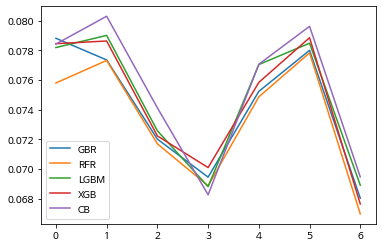

In [148]:
results.plot()

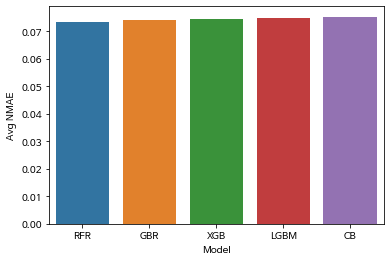

In [149]:
# Visualize in order of average NMAE
sns.barplot(data = mean_nmae_res.sort_values('Avg NMAE'), x='Model', y='Avg NMAE')

* Predict with GBR, RF, and XGB

In [ ]:
pd.set_option('max_rows', 10)
submission = pd.read_csv('sample_submission.csv')
submission['착과량(int)'] = (gb_pred + rf_pred + xgb_pred) / 3
submission

,ID,착과량(int)
0,TEST_0000,245.573472
1,TEST_0001,748.161133
2,TEST_0002,152.640217
3,TEST_0003,444.606550
4,TEST_0004,684.653017
...,...,...
2203,TEST_2203,753.195896
2204,TEST_2204,329.753771
2205,TEST_2205,365.698152
2206,TEST_2206,233.136032


In [ ]:
submission.to_csv('sub_emsemble.csv', index=False)

#### FInal scores
* public: 0.0726345495 / private: 0.0728141561